In [1]:
import numpy as np
from scipy.spatial import Delaunay, ConvexHull
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from shapely.geometry import Polygon, Point, LineString
from dataclasses import dataclass

In [2]:
@dataclass
class Gate:
    obstacle_gates: list
    boundary_gates: list
    start_end_gates: list  

In [3]:
class ObstacleMap:
    
    def __init__(self, StartConf: tuple, EndConf: tuple, MapBounds: tuple, ObstaclesNum: int, Shape: int):
        """
        Initialize an obstacle map with given parameters.

        Args:
            StartConf (tuple): Start configuration coordinates.
            EndConf (tuple): End configuration coordinates.
            MapBounds (tuple): Map boundary dimensions (x_max, y_max).
            ObstaclesNum (int): Number of obstacles to generate.
            Shape (int): Number of sides in polygon obstacles (minimum 3).

        Raises:
            Exception: If Shape is less than 3.
        """
        
        self.xmin, self.xmax = 0, MapBounds[0]
        self.ymin, self.ymax = 0, MapBounds[1]
        
        self.StartCoords = Point(StartConf[0], StartConf[1])
        self.EndCoords = Point(EndConf[0], EndConf[1])
        
        if Shape < 3:
            raise Exception("Min Num of sides in a Polygon is 3")
        else:
            self.ObstacleList, self.CentroidList = self.generate_polygon_obstacles(MapBounds, ObstaclesNum, Shape)
            self.convex_hull_vertices = self.__get_largest_polygon_coordinates()
    
    def __get_angles(self, num_of_sides: int) -> list:
        """
        Generate a list of angles for the vertices of a polygon.

        Args:
            num_of_sides (int): Number of sides in the polygon.

        Returns:
            list: List of angles in radians.
        """
        random_numbers = [random.uniform(0, 1) for _ in range(num_of_sides)]
        normalized_numbers = [num / sum(random_numbers) for num in random_numbers]
        angles = np.cumsum([2*np.pi * x for x in normalized_numbers])
        angles_list = list(angles)
        return angles_list
    
    def __get_vertices(self, center: np.array, radius: float, angles_list: list):
        """
        Calculate vertices of a polygon based on center, radius, and angles.

        Args:
            center (np.array): Center coordinates of the polygon.
            radius (float): Radius of the polygon.
            angles_list (list): List of angles in radians.

        Returns:
            np.array: Array of vertices for the polygon.
        """
        vertices = np.array([center + np.array([radius*np.cos(angle), radius*np.sin(angle)]) for angle in angles_list])
        return vertices
    
    def __get_largest_polygon_coordinates(self):
        
        points = np.array(self.CentroidList)
        points = points.reshape(-1,2)
        
        unique_coords = np.unique(points, axis=0)
        hull = ConvexHull(unique_coords)
        convex_hull_vertices = hull.points[hull.vertices]
        
        return convex_hull_vertices

    
    def generate_polygon_obstacles(self, MapBounds: tuple, ObstaclesNum: int, Shape: int):
        """
        Generate a list of polygon obstacles.

        Args:
            MapBounds (tuple): Map boundary dimensions (x_max, y_max).
            ObstaclesNum (int): Number of obstacles to generate.
            Shape (int): Number of sides in polygon obstacles.

        Returns:
            list: List of Shapely Polygon obstacles.
        """
        xmin, xmax = 0, MapBounds[0]
        ymin, ymax = 0, MapBounds[1]
        
        Boundary1 = LineString([(xmin, ymin), (xmax, ymin)])
        Boundary2 = LineString([(xmax, ymin), (xmax, ymax)])
        Boundary3 = LineString([(xmax, ymax), (xmin, ymax)])
        Boundary4 = LineString([(xmin, ymin), (xmin, ymax)])
        
        map_boundaries = [Boundary1, Boundary2, Boundary3, Boundary4]
        
        min_distance = 0.5
        ObstacleList = []
        CentroidList = []
        count = 0
        while count < ObstaclesNum:
            radius = random.uniform(0.07, 0.08) * xmax
            center = np.array([np.random.rand() * xmax, np.random.rand() * ymax])
            
            
            if Shape == 3:
                pshape = 3
            else:
                pshape = np.random.randint(low=3, high=Shape)
            
            angles_list = self.__get_angles(pshape)
            vertices = self.__get_vertices(center, radius, angles_list)
            polygon = Polygon(vertices)
            x, y = polygon.exterior.xy
            
            intersects_obstacle = False
            for existing_obstacle in ObstacleList:
                if polygon.intersects(existing_obstacle) or polygon.distance(existing_obstacle) < min_distance or \
                polygon.intersects(self.StartCoords) or polygon.intersects(self.EndCoords):
                    intersects_obstacle = True
                    break
                    
            intersects_boundaries = False
            for boundary in map_boundaries:
                if polygon.intersects(boundary):
                    intersects_boundaries = True
                    break
                    
                    
            centroid_outside = False
            x_centroid = polygon.centroid.coords[0][0]
            y_centroid = polygon.centroid.coords[0][1]
            
            if x_centroid > xmax and x_centroid < xmin and y_centroid > ymax and y_centroid < ymin:
                centroid_outside = True
                
                
            vertices_within_range = True
            for i in range(len(list(polygon.exterior.coords))):
                x_vertex = polygon.exterior.coords[i][0]
                y_vertex = polygon.exterior.coords[i][1]
                
                if (self.StartCoords.x + 1) <= x_vertex <= (self.EndCoords.x - 1) and (ymin + 1) <= y_vertex <= (ymax - 1):
                    continue
                    
                else:
                    vertices_within_range = False
                
            
            if not intersects_obstacle and not intersects_boundaries and not centroid_outside and vertices_within_range:
                ObstacleList.append(polygon)
                
                CentroidList.append(list(polygon.centroid.coords))
                count += 1         
        
        return ObstacleList, CentroidList
    
    def generate_plot(self):
        """
        Generate a plot to visualize the obstacle map.
        """
        plt.axis('equal')
        for obstacle in self.ObstacleList:
            x, y = obstacle.exterior.xy
            plt.fill(x, y, c="blue")
            
        plt.scatter(self.convex_hull_vertices[:,0], self.convex_hull_vertices[:,1])
        
        plt.plot([self.xmin, self.xmax, self.xmax, self.xmin, self.xmin], [self.ymin, self.ymin, self.ymax, self.ymax, self.ymin], color='black')
            
        plt.plot(self.StartCoords.x, self.StartCoords.y, "X", color ="black")
        plt.plot(self.EndCoords.x, self.EndCoords.y, "X", color = "black")
        
#         plt.figure(figsize=(140,14))
#         plt.figure().set_figwidth(15)
        plt.show()


In [4]:
def slope(line: LineString) -> float:
    """
    Calculate the slope of a LineString.

    This function takes a LineString object as input and calculates the slope
    of the line defined by its coordinates. The slope is calculated as the
    change in y-coordinates divided by the change in x-coordinates between the
    first and second points of the line.

    Args:
        line (LineString): A LineString object representing the line for which
            to calculate the slope.

    Returns:
        float: The calculated slope of the line, rounded to three decimal places.

    Raises:
        ZeroDivisionError: If the change in x-coordinates (denominator) is zero,
            indicating a vertical line with undefined slope.

    Example:
        >>> line = LineString([(0, 0), (2, 4)])
        >>> slope_value = slope(line)
        >>> print(slope_value)
        2.0
    """
    # Extract coordinates of the first and second points
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]

    # Calculate the change in x-coordinates
    dx = x2 - x1

    # Check for vertical line (undefined slope)
    if dx == 0:
        raise ZeroDivisionError("The line is vertical, and its slope is undefined.")

    # Calculate the slope
    slope = (y2 - y1) / dx
    
    # Round the slope to three decimal places
    slope = round(slope, 3)
    
    return slope


In [5]:
def line_eqs_delaunay(points: np.array, simplices) -> list:
    """
    Generate a list of unique LineString equations for the given Delaunay triangulation.

    Given an array of points and their Delaunay triangulation simplices, this function
    generates a list of LineString equations representing the unique lines formed by
    the vertices of the simplices.

    Args:
        points (np.array): An array of 2D points.
        simplices: The simplices of the Delaunay triangulation.

    Returns:
        list: A list of LineString objects representing unique lines formed by the
        vertices of the Delaunay triangulation.

    Example:
        >>> points = np.array([[0, 0], [1, 2], [3, 1]])
        >>> simplices = [(0, 1, 2)]
        >>> lines = line_eqs_delaunay(points, simplices)
        >>> print(lines)
        [LINESTRING (0 0, 1 2), LINESTRING (1 2, 3 1), LINESTRING (3 1, 0 0)]
    """
    lines = []

    # Generate LineString objects for each simplex
    for simplex in simplices:
        vertices = points[simplex]
        for i in range(3):
            for j in range(i + 1, 3):
                lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))

    # Create a dictionary to group lines by slope
    line_dict = defaultdict(list)

    # Calculate slope for each line and group them
    for line in lines:
        slp = slope(line)
        line_dict[slp].append(line)

    filtered_lines = []

    # Choose one representative line for each slope
    for slp, line_list in line_dict.items():
        filtered_lines.append(line_list[0])

    return filtered_lines

In [6]:
def line_eqs_inside_poly(lines, obstacle_list):
    """
    Finds intersections between a list of lines and a list of obstacles, 
    and returns the coordinates of the points where the lines intersect 
    with the obstacles.
    
    Args:
        lines (list): A list of lines represented as pairs of coordinates.
        obstacle_list (list): A list of obstacle polygons represented as 
                             Shapely geometry objects.
                             
    Returns:
        list: A list of lists containing coordinates of points where lines 
              intersect with obstacles.
    """
    
    line_eqs_in_poly = []  # Store intersections between lines and obstacles.

    for line in lines:
        for obstacle in obstacle_list:
            if obstacle.intersects(LineString(line)):
                # Append the intersection point to the list of intersections.
                line_eqs_in_poly.append(obstacle.intersection(LineString(line)))
                
    # Convert intersection points to lists of coordinates.
    line_inside_poly = [[list(coord) for coord in line.coords] for line in line_eqs_in_poly]

    return line_inside_poly


In [7]:
def LongSeg_SmallSeg(lines, line_inside_poly):
    """
    Finds and associates small line segments with corresponding long line segments
    based on matching slopes and returns a dictionary containing the associations.

    Args:
        lines (list): A list of long line segments represented as pairs of coordinates.
        line_inside_poly (list): A list of lists containing coordinates of points where
                                 lines intersect with obstacles.

    Returns:
        dict: A dictionary where keys are long line segments (LineString objects) and 
              values are lists of coordinates representing associated small line segment points.
    """

    diction_lines = {LineString(long_line_segs): [] for long_line_segs in lines}

    for long_line_segs in lines:
        for small_line_segs in line_inside_poly:
            if slope(LineString(long_line_segs)) == slope(LineString(small_line_segs)):
                for i in range(2):
                    key = LineString(long_line_segs)
                    if key in diction_lines:
                        if small_line_segs[i] not in diction_lines[key]:
                            diction_lines[key].append(small_line_segs[i])

    #filtered_diction_lines = {key: value for key, value in diction_lines.items() if len(value) == 2}

    return diction_lines


In [8]:
def gates_for_GStar(M: ObstacleMap, diction_lines):
    """
    Generates gate LineString objects for a graph G* based on the given dictionary
    of associated small line segment points with long line segments.

    Args:
        diction_lines (dict): A dictionary where keys are long line segments (LineString objects) 
                             and values are lists of coordinates representing associated small line segment points.

    Returns:
        list: A list of gate LineString objects for the graph G*.
    """
    
    # Iterate through each key-value pair in the dictionary.
    for key, value in diction_lines.items():
        # Iterate through the two endpoints of the long line segment.
        for i in range(2):
            # Check if the endpoint is in the list of associated small line segment points.
            if list(key.coords[i]) in value:
                # Remove the endpoint from the list to avoid duplicate gates.
                diction_lines[key].remove(list(key.coords[i]))

    gates1 = []  # Store the LineString gate objects.

    # Create LineString objects for the remaining points and add them to the gates list.
    for values in diction_lines.values():
        if len(values) != 0:
            gates1.append(LineString(values))
    
    # Filter out gates that have more than two coordinates.
    obstacle_gates = [gate for gate in gates1 if len(gate.coords) == 2]
    
    boundary_gates = []
    
    for point in M.convex_hull_vertices:
#         print(point)
#         print(type(point))
        if point[1] >= (0.5 * M.ymax):
            gate = LineString([point, (point[0], M.ymax)])
            
            
        else:
            gate = LineString([point, (point[0], M.ymin)])
        
       
        boundary_gates.append(gate)
        
    
    filtered_boundary_gates = []

    for gate in boundary_gates:
        count = 0
        for obstacle in M.ObstacleList:
            if gate.intersects(obstacle):
                count += 1

        if count == 1:
            filtered_boundary_gates.append(gate)
    
    updates_boundary_gates = []
    
    for gate in filtered_boundary_gates:
        for obs in M.ObstacleList:
            if gate.intersects(obs):
                new_gate = gate - obs
                updates_boundary_gates.append(new_gate)
                
            else:
                continue
    
    start_end_gates = []
    
    start_gate = LineString([(M.StartCoords.coords[0][0], M.StartCoords.coords[0][1] - 0.1), (M.StartCoords.coords[0][0], M.StartCoords.coords[0][1] + 0.1)])
    end_gate = LineString([(M.EndCoords.coords[0][0], M.EndCoords.coords[0][1] - 0.1), (M.EndCoords.coords[0][0], M.EndCoords.coords[0][1] + 0.1)])
            
    start_end_gates.append(start_gate)
    start_end_gates.append(end_gate)
        
    gates = Gate(obstacle_gates = obstacle_gates, boundary_gates = updates_boundary_gates, start_end_gates = start_end_gates)
    
    return gates


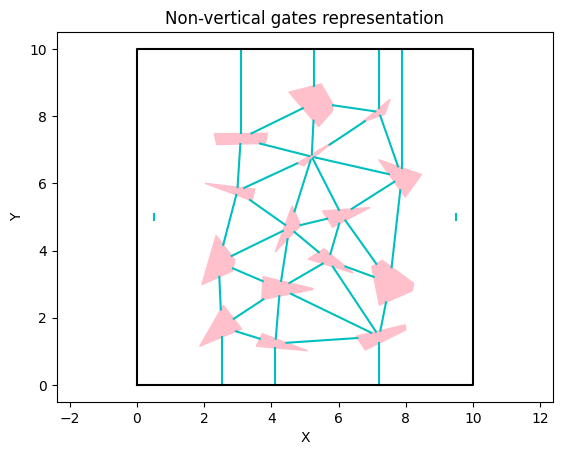

In [9]:
StartConf = (0.5, 5, 5.78) #tuple : (x,y, theta)
EndConf = (9.5, 5, 2.79) #tuple : (x, y, theta)
MapBounds=(10.0, 10.0) #tuple : (xmax, ymax)
ObstaclesNum= 15 # int: number of obstacles
Shape=6 #int: maximum number of sides of convex obstacles

#create a object M of ObstacleMap type using the above defined attributes.
M = ObstacleMap(StartConf, EndConf, MapBounds, ObstaclesNum, Shape)

#Extracting obstacle_list : list of polygons, centroid_list: list of centroids from object M
obstacle_list, centroid_list = M.ObstacleList, M.CentroidList

#putting centroids list in a 2D array
points = np.array(centroid_list)
points = points.reshape(-1,2)

#creating a Delaunay Object out of centroids for Delaunay Triangulations
tri = Delaunay(points)

#getting indices of points that form a triangle
simplices = tri.simplices

#getting line equations from simplices and points
lines = line_eqs_delaunay(points, simplices)

#using obstacle list and lines, here we get the lines that are inside the polygon
line_inside_poly = line_eqs_inside_poly(lines, obstacle_list)

#associating bigger lines with shorter lines that are inside the polygon based on their slopes
diction_lines = LongSeg_SmallSeg(lines, line_inside_poly)

#here we get gates that is intersection of lines with the obstacles i.e. non vertical gates
gates = gates_for_GStar(M, diction_lines)



# Create a figure and axis
fig, ax = plt.subplots()



for obstacle in obstacle_list:
    x,y = obstacle.exterior.xy
    ax.fill(x, y, color = 'pink')


# plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'k--')
# plt.plot(points[:,0], points[:,1], 'o')

for ObsGate in gates.obstacle_gates:
    x, y = ObsGate.xy
    plt.plot(x, y, 'c-', linewidth=1.5)
    
for BoundGate in gates.boundary_gates:
    x, y = BoundGate.xy
    plt.plot(x, y, 'c-', linewidth = 1.5)
    
for StartEndGate in gates.start_end_gates:
    x, y = StartEndGate.xy
    plt.plot(x, y, 'c-', linewidth = 1.5)
    
    
plt.plot([M.xmin, M.xmax, M.xmax, M.xmin, M.xmin], [M.ymin, M.ymin, M.ymax, M.ymax, M.ymin], color='black')

# Set axis limits
# ax.set_xlim(-2, 12)
# ax.set_ylim(-2, 12)
plt.axis('equal')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Non-vertical gates representation')

plt.plot()

# Show the plot
plt.show()


In [10]:
points

array([[6.093961  , 5.04998916],
       [5.28314335, 8.40303907],
       [4.25654874, 2.87080197],
       [3.08858436, 7.32886789],
       [4.53664712, 4.67710318],
       [2.98808431, 5.76998991],
       [2.43310123, 3.6496609 ],
       [7.52858033, 3.03945439],
       [5.20225028, 6.79401163],
       [2.51918343, 1.72861514],
       [7.88247773, 6.18520323],
       [5.70354015, 3.70941208],
       [7.21134934, 1.43925908],
       [4.12027659, 1.23204014],
       [7.20274196, 8.12548817]])

In [11]:
tri

In [12]:
simplices

array([[14,  8, 10],
       [ 8, 14,  1],
       [ 3,  8,  1],
       [ 4,  5,  6],
       [ 5,  3,  6],
       [ 8,  5,  4],
       [ 5,  8,  3],
       [ 8,  0, 10],
       [ 0,  8,  4],
       [ 0,  7, 10],
       [11,  0,  4],
       [ 0, 11,  7],
       [ 7, 11, 12],
       [ 9,  2,  6],
       [13,  2,  9],
       [ 2,  4,  6],
       [ 2, 11,  4],
       [ 2, 13, 12],
       [11,  2, 12]], dtype=int32)

In [13]:
obstacle_list

[<POLYGON ((5.521 5.178, 5.822 4.693, 6.938 5.279, 5.521 5.178))>,
 <POLYGON ((5.483 8.959, 4.523 8.711, 5.408 7.69, 5.808 8.134, 5.839 8.343, 5...>,
 <POLYGON ((5.236 2.869, 3.754 3.223, 3.714 2.537, 5.237 2.839, 5.236 2.869))>,
 <POLYGON ((2.302 7.477, 2.377 7.154, 3.826 7.187, 3.886 7.489, 2.302 7.477))>,
 <POLYGON ((4.62 5.331, 4.112 3.955, 4.878 4.746, 4.62 5.331))>,
 <POLYGON ((2.028 6.001, 3.426 5.482, 3.51 5.828, 2.028 6.001))>,
 <POLYGON ((2.357 4.452, 1.934 2.984, 2.842 3.389, 2.915 3.716, 2.357 4.452))>,
 <POLYGON ((7.296 3.713, 6.988 3.517, 7.218 2.372, 8.2 2.805, 8.235 3.028, 7....>,
 <POLYGON ((4.765 6.595, 4.965 6.523, 5.876 7.264, 4.765 6.595))>,
 <POLYGON ((2.57 2.373, 1.868 1.148, 3.119 1.664, 2.57 2.373))>,
 <POLYGON ((7.194 6.704, 7.985 5.588, 8.468 6.263, 7.194 6.704))>,
 <POLYGON ((5.57 4.054, 5.097 3.747, 6.444 3.328, 5.57 4.054))>,
 <POLYGON ((7.987 1.789, 6.526 1.448, 6.798 1.04, 8.003 1.637, 7.987 1.789))>,
 <POLYGON ((3.731 1.526, 3.552 1.152, 5.078 1.018, 3.

In [14]:
centroid_list

[[(6.093960995831606, 5.049989155901104)],
 [(5.283143351234279, 8.403039069609887)],
 [(4.25654873939635, 2.8708019727303955)],
 [(3.08858435977731, 7.328867894261272)],
 [(4.536647120062123, 4.677103176829991)],
 [(2.988084306209333, 5.769989908631878)],
 [(2.4331012252567525, 3.649660896382922)],
 [(7.52858033473942, 3.039454388033202)],
 [(5.20225028494805, 6.7940116254592215)],
 [(2.519183429203459, 1.728615136436113)],
 [(7.882477726522776, 6.185203232847521)],
 [(5.703540151312193, 3.7094120789083234)],
 [(7.211349343356156, 1.4392590812703703)],
 [(4.120276585395722, 1.2320401391935523)],
 [(7.202741960941462, 8.125488171477635)]]

In [15]:
diction_lines

{<LINESTRING (7.203 8.125, 5.202 6.794)>: [[5.733080380453377,
   7.14731868020369],
  [6.785953661259079, 7.848084445013034]],
 <LINESTRING (7.203 8.125, 7.882 6.185)>: [[7.770602009261684,
   6.504549043663429],
  [7.243365683002388, 8.009529000198038]],
 <LINESTRING (5.202 6.794, 7.882 6.185)>: [[5.277690874003391,
   6.776875444011322],
  [7.500268149167297, 6.272021386718027]],
 <LINESTRING (5.202 6.794, 5.283 8.403)>: [[5.256080827661135,
   7.864743945735033],
  [5.205585779275248, 6.860357261230774]],
 <LINESTRING (7.203 8.125, 5.283 8.403)>: [[5.8364955979162065,
   8.323030982360075],
  [7.093643479244953, 8.141262501291486]],
 <LINESTRING (3.089 7.329, 5.202 6.794)>: [[3.6652368836855937,
   7.182947853795106],
  [5.12696589786476, 6.813062094076283]],
 <LINESTRING (3.089 7.329, 5.283 8.403)>: [[4.936755392798122,
   8.233492494699659],
  [3.409098426799558, 7.4857499709925435]],
 <LINESTRING (4.537 4.677, 2.988 5.77)>: [[4.411374158345978,
   4.765513641351268],
  [3.364039

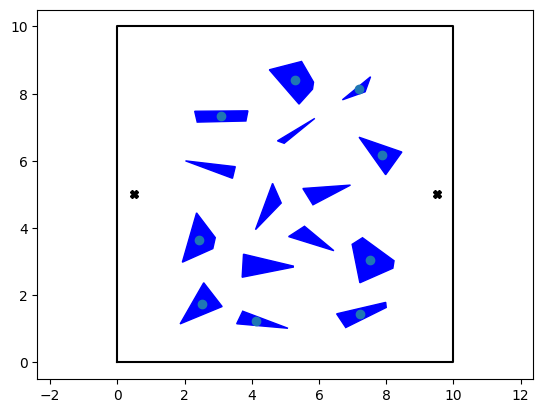

In [16]:
M.generate_plot()